In [5]:
import numpy as np
from quaos.core.circuits.target import find_map_to_target_pauli_sum
from quaos.core.circuits import Gate, SWAP, Hadamard
from quaos.utils import get_linear_dependencies
from quaos.graph_utils import find_one_permutation, mapping_key, brute_force_all_permutations, find_swapped_dependent_elements
from quaos.models import ToricCode, Hadamard_Symmetric_PauliSum, SWAP_symmetric_PauliSum, ising_chain_hamiltonian, ising_2d_hamiltonian
from quaos.models.random_hamiltonian import random_gate_symmetric_hamiltonian
from scripts.experiments.symmetries.src.pauli import symplectic_pauli_reduction 
from scripts.experiments.symmetries.src.permutations_matroid import find_permutations_matroid
from scripts.experiments.symmetries.src.matroid_w_spm import find_k_automorphisms_symplectic
from scripts.experiments.symmetries import symplectic_pauli_reduction, pauli_reduce
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from typing import Callable, List, Optional, Tuple, Set, Union, Dict
import sys
np.set_printoptions(threshold=sys.maxsize)
import time

In [2]:
seed = None
 
d = 2
n_qubits = 8
n_sym_q = 2
n_paulis = 18
H, C = Hadamard_Symmetric_PauliSum(n_paulis, n_qubits, n_sym_q, seed=seed)
H.combine_equivalent_paulis()
H.remove_trivial_paulis()


In [4]:
independent_paulis, dependencies = get_linear_dependencies(H.tableau(), d)

print(independent_paulis)
print(dependencies)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16]
{15: [(1, 1), (2, 1), (5, 1), (7, 1), (9, 1), (11, 1), (14, 1)], 17: [(1, 1), (2, 1), (8, 1)]}


In [5]:
def permutation_to_swaps(perm: dict[int, int]) -> list[tuple[int, int]]:
    """
    Decompose a permutation (given as dict label->label) into a sequence of swaps (transpositions).
    Each swap is a tuple (i,j) meaning 'swap i and j'.
    Applying these swaps in order reproduces the permutation.

    Parameters
    ----------
    perm : dict[int,int]
        Permutation mapping, e.g. {0:1, 1:2, 2:0, 3:3}.

    Returns
    -------
    swaps : list[tuple[int,int]]
        Sequence of swaps to realize the permutation.
    """
    swaps: list[tuple[int,int]] = []
    seen = set()
    for start in sorted(perm.keys()):
        if start in seen or perm[start] == start:
            continue
        # build the cycle
        cycle = []
        cur = start
        while cur not in seen:
            seen.add(cur)
            cycle.append(cur)
            cur = perm[cur]
        if len(cycle) > 1:
            # decompose cycle (c0 c1 ... c_{k-1}) as (c0 ck-1)(c0 ck-2)...(c0 c1)
            c0 = cycle[0]
            for j in range(len(cycle) - 1, 0, -1):
                swaps.append((c0, cycle[j]))
    return swaps


def build_spm_checker(hamiltonian):
    def spm_checker(permutation):
        pairs = permutation_to_swaps(permutation)
        if pairs == []:
            return False
        H_target = hamiltonian.copy()
        for p in pairs:
            H_target.swap_paulis(p[0], p[1])
        return np.array_equal(H_target.symplectic_product_matrix(), hamiltonian.symplectic_product_matrix())

    return spm_checker


In [6]:
checker = build_spm_checker(H)
perms = find_permutations_matroid(independent_paulis, dependencies, checker, p=2, k=1)[0]
print(perms)

{0: 10, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 0, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17}


In [7]:
n_independent = len(independent_paulis)
automorphism = []
for i in independent_paulis:
    automorphism.append(perms[i])

H_t = H.copy()
H_t = H_t[automorphism]
H_i = H[independent_paulis]

print(H_i)
print(H_t)
print(np.array_equal(H_i.symplectic_product_matrix(), H_t.symplectic_product_matrix()))
F, h, _, _ = find_map_to_target_pauli_sum(H_i, H_t)


(1+0j)|x1z0 x0z0 x1z0 x0z0 x1z0 x0z1 x1z0 x1z0 | 0 
(1+0j)|x0z0 x1z0 x1z1 x1z1 x0z0 x0z1 x1z1 x1z0 | 0 
(1+0j)|x0z0 x1z0 x0z0 x0z0 x0z1 x0z0 x0z1 x1z0 | 0 
(1+0j)|x0z0 x0z0 x1z1 x1z1 x1z1 x1z0 x1z0 x0z0 | 0 
(1+0j)|x0z0 x0z0 x1z1 x1z0 x1z0 x1z0 x0z1 x1z0 | 0 
(1+0j)|x0z0 x0z0 x1z0 x1z0 x1z0 x1z0 x0z0 x0z1 | 0 
(1+0j)|x0z0 x0z0 x1z0 x1z1 x1z1 x0z1 x0z1 x0z1 | 0 
(1+0j)|x0z0 x0z0 x1z1 x1z1 x0z1 x1z1 x1z1 x1z0 | 0 
(1+0j)|x0z0 x0z1 x1z1 x1z1 x0z0 x0z1 x1z1 x1z0 | 0 
(1+0j)|x0z0 x0z0 x1z0 x0z1 x1z1 x1z1 x1z1 x0z1 | 0 
(1+0j)|x0z1 x0z0 x1z0 x0z0 x1z0 x0z1 x1z0 x1z0 | 0 
(1+0j)|x0z0 x0z0 x1z1 x0z1 x1z0 x0z0 x1z0 x0z1 | 0 
(1+0j)|x0z0 x0z0 x1z0 x0z1 x1z0 x0z0 x1z1 x0z1 | 0 
(1+0j)|x0z0 x0z0 x1z0 x0z0 x1z1 x0z0 x0z1 x1z1 | 0 
(1+0j)|x0z0 x0z0 x1z1 x0z0 x0z0 x0z1 x0z0 x0z0 | 0 
(1+0j)|x0z0 x0z0 x0z0 x1z0 x0z1 x0z0 x0z1 x1z0 | 0 

(1+0j)|x0z1 x0z0 x1z0 x0z0 x1z0 x0z1 x1z0 x1z0 | 0 
(1+0j)|x0z0 x1z0 x1z1 x1z1 x0z0 x0z1 x1z1 x1z0 | 0 
(1+0j)|x0z0 x1z0 x0z0 x0z0 x0z1 x0z0 x0z1 x1z0 | 0 
(1+0j)|x0z0

In [8]:
G = Gate('Symmetry', [i for i in range(H.n_qudits())], F.T, 2, h)
print(F)


[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [27]:
# test in loop
n_tests = 5
passed = 0
seed = None
d = 2
total_time_automorphism_finder = 0.0
total_time_building_H = 0.0
for _ in range(n_tests):
    n_qubits = 14
    n_paulis = 30
    n_sym_q = 2
    start_time_building_H = time.time()
    H, C = Hadamard_Symmetric_PauliSum(n_paulis, n_qubits, n_sym_q, seed=seed)
    total_time_building_H += time.time() - start_time_building_H
    H.combine_equivalent_paulis()
    S = H.symplectic_product_matrix()
    start_time_automorphism_finder = time.time()
    independent_paulis, dependencies = get_linear_dependencies(H.tableau(), d)
    perms = find_k_automorphisms_symplectic(independent_paulis, dependencies, S=S, p=2)
    total_time_automorphism_finder += time.time() - start_time_automorphism_finder
    n_independent = len(independent_paulis)
    automorphism = []
    for i in independent_paulis:
        automorphism.append(perms[0][i])

    H_t = H.copy()
    H_t = H_t[automorphism]
    H_i = H[independent_paulis]

    F, h, _, _ = find_map_to_target_pauli_sum(H_i, H_t)
    G = Gate('Symmetry', [i for i in range(H.n_qudits())], F.T, 2, h)
    
    if G.act(H).standard_form() == H.standard_form() and not np.array_equal(G.symplectic, np.eye(2 * H.n_qudits())):
        print('Got Gate')
        passed += 1
    else:
        print('failed')
        print(independent_paulis, dependencies)
        print(perms)
        print(automorphism)
        print(G.symplectic)
        print(G.act(H).standard_form())
        print(H.standard_form())

print(f'Passed {passed}/{n_tests}')
print(f'Total time building H: {total_time_building_H:.4f} s')
print(f'Total time finding automorphisms: {total_time_automorphism_finder:.4f} s')


Got Gate
Got Gate
Got Gate
Got Gate
Got Gate
Passed 5/5
Total time building H: 82.3687 s
Total time finding automorphisms: 0.1628 s


In [15]:


# test in loop
n_tests = 10
passed = 0
seed = None
d = 2

sym = SWAP(0, 1, 2)
# sym = Hadamard(0, 2)
n_qs = [10, 20, 30, 40, 50, 60]
times_mean = np.zeros(len(n_qs))
times_median = np.zeros(len(n_qs))
times_max = np.zeros(len(n_qs))
times_min = np.zeros(len(n_qs))

for n_qubits in n_qs:
    n_paulis = int(2.1 * n_qubits)

    test_times = []
    for _ in range(n_tests):
        t_test = 0.0
        start_time_tests = time.time()
        # n_qubits = 100
        # n_paulis = 210
        H = random_gate_symmetric_hamiltonian(sym, n_qubits, n_paulis, scrambled=True)
        H.weights = np.ones(H.n_paulis())

        independent_paulis, dependencies = get_linear_dependencies(H.tableau(), d)
        S = H.symplectic_product_matrix()
        
        # perms = find_permutations_matroid(independent_paulis, dependencies, checker, p=2, k=1)
        # S, s_labels = _prepare_S_input(H.symplectic_product_matrix(), p=2)
        perms = find_k_automorphisms_symplectic(independent_paulis, dependencies, S=S, p=2)
        n_independent = len(independent_paulis)
        automorphism = []
        for i in independent_paulis:
            automorphism.append(perms[0][i])

        H_t = H.copy()
        H_t = H_t[automorphism]
        H_i = H[independent_paulis]

        F, h, _, _ = find_map_to_target_pauli_sum(H_i, H_t)
        G = Gate('Symmetry', [i for i in range(H.n_qudits())], F.T, 2, h)
        
        if np.array_equal(G.act(H).standard_form().tableau(), H.standard_form().tableau()) and not np.array_equal(G.symplectic, np.eye(2 * H.n_qudits())):
            # print(G.symplectic)
            passed += 1
        else:
            print('failed')
            print(independent_paulis, dependencies)
            print(perms)
            print(automorphism)
            print(G.symplectic)
            print(G.act(H).standard_form())
            print(H.standard_form())
        t_test = time.time() - start_time_tests
        test_times.append(t_test)
    times_mean[n_qs.index(n_qubits)] = np.mean(test_times)
    times_median[n_qs.index(n_qubits)] = np.median(test_times)
    times_max[n_qs.index(n_qubits)] = np.max(test_times)
    times_min[n_qs.index(n_qubits)] = np.min(test_times)

print(f'Passed {passed}/{len(n_qs) * n_tests}')
# print(perms)
# print(G.symplectic)


Passed 60/60


Text(0, 0.5, 'Average time per test (s)')

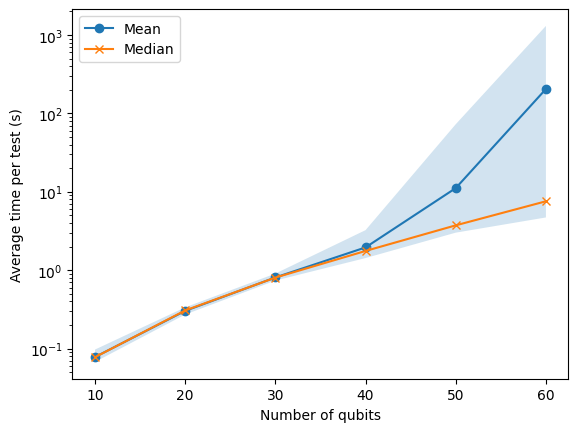

In [18]:
import matplotlib.pyplot as plt
plt.semilogy(n_qs, times_mean, marker='o', label='Mean')
plt.semilogy(n_qs, times_median, marker='x', label='Median')
# fill in area between max and min
plt.fill_between(n_qs, times_max, times_min, alpha=0.2)
plt.legend()
# plt.plot(n_qs, times_max, marker='^', label='Max')
# plt.plot(n_qs, times_min, marker='d', label='Min')
plt.xlabel('Number of qubits')
plt.ylabel('Average time per test (s)')

In [ ]:
# ising model
Ns = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
J = 1
tv_field = 0.5
d = 2
n_correct = 0
times = []
for N in Ns:
    
    H = ising_chain_hamiltonian(N, J, tv_field, periodic=True)

    h_red, conditioned_hamiltonians, C, all_phases = pauli_reduce(H)
    # print(h_red)
    # print(conditioned_hamiltonians[0])
    start_time = time.time()
    independent_paulis, dependencies = get_linear_dependencies(H.tableau(), d)
    S = H.symplectic_product_matrix()

    # perms = find_permutations_matroid(independent_paulis, dependencies, checker, p=2, k=1)
    # S, s_labels = _prepare_S_input(H.symplectic_product_matrix(), p=2)
    perms = find_k_automorphisms_symplectic(independent_paulis, dependencies, S=S, p=2, coeffs=H.weights)
    n_independent = len(independent_paulis)
    automorphism = []
    for i in independent_paulis:
        automorphism.append(perms[0][i])

    H_t = H.copy()
    H_t = H_t[automorphism]
    H_i = H[independent_paulis]

    F, h, _, _ = find_map_to_target_pauli_sum(H_i, H_t)
    G = Gate('Symmetry', [i for i in range(H.n_qudits())], F.T, 2, h)
    if np.array_equal(G.act(H).standard_form().tableau(), H.standard_form().tableau()) and not np.array_equal(G.symplectic, np.eye(2 * H.n_qudits())):
        print('Got Gate')
        # print(G.symplectic)
        # print(H.standard_form())
        # print(G.act(H).standard_form())
        n_correct += 1
    else:
        print('failed')
        print(independent_paulis, dependencies)
        print(perms)
        print(automorphism)
        print(G.symplectic)
        print(G.act(H).standard_form())
        print(H.standard_form())
    t = time.time() - start_time
    times.append(t)


Got Gate
Got Gate
Got Gate
Got Gate
Got Gate
Got Gate


Text(0, 0.5, 'Time (s)')

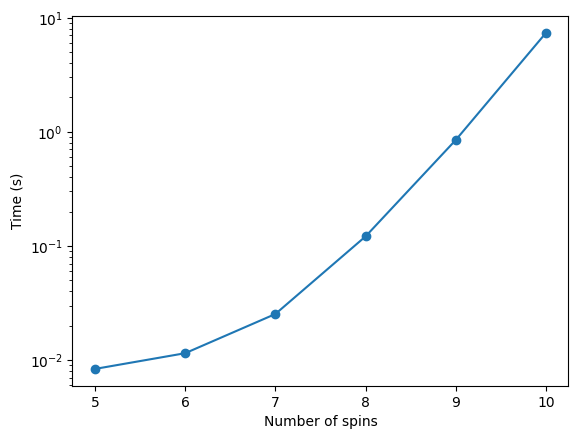

In [6]:
plt.figure()
plt.semilogy(Ns, times, marker='o')
plt.xlabel('Number of spins')
plt.ylabel('Time (s)')


In [ ]:
# 2d ising model
Nx = 3
Nys = [3, 4, 5, 6, 7]
d = 2
J = 1
tv_field = 1
times = []
n_correct = 0
for Ny in Nys:
    
    H = ising_2d_hamiltonian(Nx, Ny, J, tv_field, periodic=True)
    start_time = time.time()
    h_red, conditioned_hamiltonians, C, all_phases = pauli_reduce(H)
    print(h_red)
    print(conditioned_hamiltonians[0])

    independent_paulis, dependencies = get_linear_dependencies(H.tableau(), d)
    S = H.symplectic_product_matrix()

    # perms = find_permutations_matroid(independent_paulis, dependencies, checker, p=2, k=1)
    # S, s_labels = _prepare_S_input(H.symplectic_product_matrix(), p=2)
    perms = find_k_automorphisms_symplectic(independent_paulis, dependencies, S=S, p=2)
    n_independent = len(independent_paulis)
    automorphism = []
    for i in independent_paulis:
        automorphism.append(perms[0][i])

    H_t = H.copy()
    H_t = H_t[automorphism]
    H_i = H[independent_paulis]

    F, h, _, _ = find_map_to_target_pauli_sum(H_i, H_t)
    G = Gate('Symmetry', [i for i in range(H.n_qudits())], F.T, 2, h)
    if np.array_equal(G.act(H).standard_form().tableau(), H.standard_form().tableau()) and not np.array_equal(G.symplectic, np.eye(2 * H.n_qudits())):
        print('Got Gate')
        n_correct += 1
    else:
        print('failed')
        print(independent_paulis, dependencies)
        print(perms)
        print(automorphism)
        print(G.symplectic)
        print(G.act(H).standard_form())
        print(H.standard_form())
    t = time.time() - start_time
    times.append(t)


(1+0j)|x0z1 x0z0 x0z0 x0z0 x0z0 x0z0 x0z0 x0z0 x0z0 | 0 
(1+0j)|x0z1 x0z1 x0z0 x0z0 x0z0 x0z0 x0z0 x0z0 x0z0 | 0 
(1+0j)|x0z0 x0z0 x0z0 x0z1 x0z0 x0z0 x0z0 x0z0 x0z0 | 0 
(1+0j)|x0z0 x0z0 x0z0 x0z1 x0z1 x0z0 x0z0 x0z0 x0z0 | 0 
(1+0j)|x0z0 x0z0 x0z0 x0z0 x0z0 x0z0 x0z1 x0z0 x0z0 | 0 
(1+0j)|x0z1 x0z1 x0z0 x0z1 x0z1 x0z0 x0z0 x0z0 x0z0 | 0 
(1+0j)|x0z0 x0z1 x0z1 x0z0 x0z0 x0z0 x0z0 x0z0 x0z0 | 0 
(1+0j)|x0z0 x0z1 x0z0 x0z1 x0z0 x0z0 x0z0 x0z0 x0z0 | 0 
(1+0j)|x0z0 x0z0 x0z0 x0z0 x0z1 x0z1 x0z0 x0z0 x0z0 | 0 
(1+0j)|x0z0 x0z0 x0z0 x0z0 x0z1 x0z0 x0z1 x0z0 x0z0 | 0 
(1+0j)|x0z0 x0z0 x0z0 x0z0 x0z0 x0z0 x0z0 x0z1 x0z0 | 0 
(1+0j)|x0z0 x0z1 x0z0 x0z1 x0z1 x0z0 x0z1 x0z0 x0z0 | 0 
(1+0j)|x0z1 x0z1 x0z1 x0z0 x0z0 x0z0 x0z0 x0z0 x0z0 | 0 
(1+0j)|x0z0 x0z0 x0z1 x0z1 x0z1 x0z1 x0z0 x0z0 x0z0 | 0 
(1+0j)|x0z0 x0z0 x0z0 x0z1 x0z1 x0z1 x0z0 x0z0 x0z0 | 0 
(1+0j)|x0z0 x0z0 x0z0 x0z0 x0z0 x0z1 x0z1 x0z1 x0z0 | 0 
(1+0j)|x0z0 x0z0 x0z0 x0z0 x0z0 x0z0 x0z1 x0z1 x0z0 | 0 
(1+0j)|x0z0 x0z0 x0z1 x0z1 x0z1

In [ ]:
plt.figure()
plt.semilogy(Nys, times, marker='o')
plt.xlabel('Number of spins in y direction (Nx=3)')
plt.ylabel('Time (s)')